# generate videos of spiral tips with streams predictive of extinction dynamics
Tim Tyree<br>
3.22.2022

In [1]:
from lib.my_initialization import *
from lib.model.minimal_model_cuda import *
from lib import *
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


In [2]:
import shutil
#reset matplotlib
import matplotlib as mpl
# import seaborn as sns
# sns.reset_orig()
mpl.rc_file_defaults()

In [3]:
# 993MiB /  7982MiB
# 7982/993=8.03...>8
npartitions_gpu=1
npartitions=os.cpu_count()-1
assert npartitions>0

# define module

In [8]:
# !pip install mayavi


ImportError: Could not import backend for traitsui.  Make sure you
        have a suitable UI toolkit like PyQt/PySide or wxPython
        installed.

In [6]:
import vtk

In [4]:
import mayavi

ModuleNotFoundError: No module named 'mayavi'

In [4]:
#input: gpu output in cpu memory
#ouput:  dict_out,img,dimg_dt
def measure_system(gpu_result_u,gpu_result_v,gpu_result_w,V_threshold,**kwargs):
    """
    kwargs may not be conected to anything
    returns dict_out,img,dimg_dt
    Example Usage:
dict_out,img,dimg_dt=measure_system(gpu_result_u,gpu_result_v,gpu_result_w,V_threshold)
    """
    #stack txt
    txt=np.stack((gpu_result_u,gpu_result_v,gpu_result_w),axis=-1)
    # #DONE: compute spiral tip locations and verify that they look reasonable
    #compute flow map
    zero_txt=np.zeros_like(txt)
    dtxt_dt=zero_txt#.copy()
    get_time_step_fk(txt, dtxt_dt)
    img=txt[...,0]
    dimgdt=dtxt_dt[...,0]
    #compute spiral tip locations
    dict_out=compute_all_spiral_tips(t=9999.,img=img,dimgdt=dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)

    #compress data to be plotted
    # dimg_dt=dtxt_dt[...,0]
    # img=txt[...,0]
    dimg_dt=dtxt_dt[...,0].astype(np.float32) #looks the same as float64
    img=txt[...,0].astype(np.float32)
    # dVdt=dtxt_dt[...,0].astype(np.float16) #this bugs up the streamplots
    # img=txt[...,0].astype(np.float16)
    return dict_out,img,dimg_dt

In [5]:
#DONE: dev viewer routine_to_png
#input: dict_out,img,dimg_dt,save_dir
#output: save_dir
def routine_to_png_streaming_tips(task):
    dict_out,img,dimg_dt,save_dir=task
    #define constant parameters
    # fontsize=22
    # xy=(0.75, 0.9)
    inch=6
    fontsize=30
    xy=(0.67, 0.9)
    #define constant coordinate mesh for stream generation
    width=200.#pixel
    height=200.#pixel
    DX=0.025#cm/pixel
    #generate plot
    #fig, ax = plt.subplots(figsize=(inch,inch))#,constrained_layout=True)
    fig = plt.figure(figsize=(inch,inch))#,constrained_layout=True)
    ax=fig.add_subplot()
    #plot the mesh
    X_=np.arange(width)
    Y_=np.arange(height)
    X,Y = np.meshgrid(X_, Y_)
    ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone', shading='gouraud')
    #ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone', shading='auto')
    #     ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone')
    #     ax.pcolormesh(X, Y, img, shading='auto',cmap='bone')

    #compute vector field #note notes are for LR model
#     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX
#     ddVdtdy=np.gradient(dimg_dt,axis=0)/DX
#     ddVdtdx=np.gradient(dimg_dt,axis=0)/DX #not stable in time
#     ddVdtdy=np.gradient(dimg_dt,axis=1)/DX #not stable in time
#     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX  #appears to be the opposite direction, also unstable at V_threshold=-50
#     ddVdtdy=-np.gradient(dimg_dt,axis=0)/DX #appears to be the opposite direction, also unstable at V_threshold=-50
    ddVdtdx=-np.gradient(dimg_dt,axis=1)/DX
    ddVdtdy=np.gradient(dimg_dt,axis=0)/DX #appears to be the opposite direction, also unstable at V_threshold=-50
#     vx=-ddVdtdx #looks good, opposite direction?
#     vy=-ddVdtdy
    vx=ddVdtdx #still looks meh?
    vy=ddVdtdy
    use_streamplot=False
    if use_streamplot:
        #compute the streamplot
        strm = ax.streamplot(X_,Y_, vx, vy, color=(.75,.90,.93),integration_direction='both',
                             density=0.5)#density=2)#way too much 
    x_values=np.array(dict_out['x'])
    y_values=np.array(dict_out['y'])
    if x_values.shape[0]>0:
        boo=(x_values<width-1.)&(y_values<height-1.)
        x_values=x_values[boo]
        y_values=y_values[boo]
        if use_streamplot:
            start_points = list(zip(x_values,y_values))
            strmS = ax.streamplot(X_,Y_, vx, vy, start_points=start_points, 
                              color="crimson", #"orange", 
                              linewidth=2,
        #                       integration_direction='forward')
        #                       integration_direction='backward')
                              integration_direction='both')
        ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=150,alpha=0.9,zorder=10)

        if use_streamplot:
            #record the stream for later analysis
            stream_array=strmS.lines.properties()['segments']
            dict_out['stream_array']=stream_array
    
    #complicated formatting
    #add text of label
#     label=f"Vth={V_threshold}"
    if use_streamplot:
        #record the stream for later analysis
        label=r"$-\nabla \partial_tV$"#+'\n'
        ax.annotate(label, xy=xy, 
                xycoords='axes fraction',
    #             xycoords='data',
    #             xycoords='polar',
                fontsize=fontsize,alpha=0.8)
    #(alternative method with small font...)add text box with label
    # anchored_text = mpl.offsetbox.AnchoredText(label, loc='upper right')
    # ax.add_artist(anchored_text)
    # anchored_text.set_alpha(0.1)
    # annotating=False
    # if annotating:
    #     time_step_string=f"  t = {t/10**3:.2f} sec"#f"  t = {t:.0f} ms"#
    #     message_string=f"  num. = {n_tips}"
    #     ax.text(.0,.95,time_step_string,
    #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
    #             transform=ax.transAxes)
    #     ax.text(.0,.9,message_string,
    #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
    #             transform=ax.transAxes)
    ax.axis("off")
    plt.savefig(save_dir,dpi=720/inch, bbox_inches='tight',pad_inches=0);
    plt.close();
    return save_dir

# #DONE: dev viewer routine_to_png
# #input: dict_out,img,dimg_dt,save_dir
# #output: save_dir
# def routine_to_png_streaming_tips(task):
#     dict_out,img,dimg_dt,save_dir=task
#     #define constant parameters
#     # fontsize=22
#     # xy=(0.75, 0.9)
#     inch=6
#     fontsize=30
#     xy=(0.67, 0.9)
#     #define constant coordinate mesh for stream generation
#     width=200.#pixel
#     height=200.#pixel
#     DX=0.025#cm/pixel
#     #generate plot
#     #fig, ax = plt.subplots(figsize=(inch,inch))#,constrained_layout=True)
#     fig = plt.figure(figsize=(inch,inch))#,constrained_layout=True)
#     ax=fig.add_subplot()
#     ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone', shading='gouraud')
#     #ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone', shading='auto')
#     #     ax.pcolormesh(X, Y, img, vmin=0.,vmax=1.,cmap='bone')
#     #     ax.pcolormesh(X, Y, img, shading='auto',cmap='bone')

#     #compute the streamplot
#     X_=np.arange(width)
#     Y_=np.arange(height)
#     #X,Y = np.meshgrid(X_, Y_)
#     #compute vector field
#     ddVdtdx=np.gradient(dimg_dt,axis=1)/DX
#     ddVdtdy=np.gradient(dimg_dt,axis=0)/DX
#     vx=-ddVdtdx #looks good
#     vy=-ddVdtdy
#     # vx=ddVdtdx #looks meh
#     # vy=ddVdtdy
#     strm = ax.streamplot(X_,Y_, vx, vy, color=(.75,.90,.93),integration_direction='both',
#                          density=0.5)#density=2)#way too much 
#     x_values=np.array(dict_out['x'])
#     y_values=np.array(dict_out['y'])
#     if x_values.shape[0]>0:
#         boo=(x_values<width-1.)&(y_values<height-1.)
#         x_values=x_values[boo]
#         y_values=y_values[boo]
#         start_points = list(zip(x_values,y_values))
#         strmS = ax.streamplot(X_,Y_, vx, vy, start_points=start_points, 
#                               color="crimson", #"orange", 
#                               linewidth=2,
#         #                       integration_direction='forward')
#         #                       integration_direction='backward')
#                               integration_direction='both')
#         ax.scatter(x=x_values,y=y_values,color='yellow',marker='*',s=150,alpha=0.9,zorder=10)

#     #complicated formatting
#     #add text of label
# #     label=f"Vth={V_threshold}"
#     label=r"$-\nabla \partial_tV$"#+'\n'
#     ax.annotate(label, xy=xy, 
#                 xycoords='axes fraction',
#     #             xycoords='data',
#     #             xycoords='polar',
#                 fontsize=fontsize,alpha=0.8)
#     #add text box with label
#     # anchored_text = mpl.offsetbox.AnchoredText(label, loc='upper right')
#     # ax.add_artist(anchored_text)
#     # anchored_text.set_alpha(0.1)
#     # annotating=False
#     # if annotating:
#     #     time_step_string=f"  t = {t/10**3:.2f} sec"#f"  t = {t:.0f} ms"#
#     #     message_string=f"  num. = {n_tips}"
#     #     ax.text(.0,.95,time_step_string,
#     #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
#     #             transform=ax.transAxes)
#     #     ax.text(.0,.9,message_string,
#     #             horizontalalignment='left',color=textcolor,fontsize=fontsize,
#     #             transform=ax.transAxes)
#     ax.axis("off")
#     plt.savefig(save_dir,dpi=720/inch, bbox_inches='tight',pad_inches=0);
#     plt.close();
#     return save_dir

In [6]:
1

1

# test my gpu accelerated one_step method for the Fenton-Karma model

200000 time steps took 14293 ms.


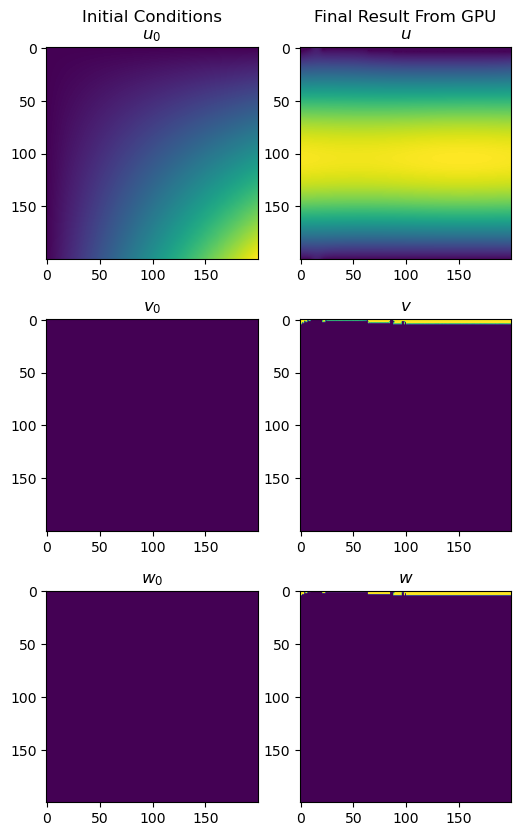

In [7]:
# from lib.model.minimal_model_cuda import *
#the following might be needed for the kernel_autotuner.
# drv.init()

#define how resources are used
width  = 200
height = 200
block_size_x=10
block_size_y=10
threads = (block_size_x,block_size_y,1)
grid = (int(width/block_size_x), int(height/block_size_y), 1)
block_size_string = f"#define block_size_x {block_size_x}\n#define block_size_y {block_size_y}\n"

#set spatial discretization
DX=0.025 #cm
# DY=0.025
DT=0.025 #ms

#initialize PyCuda and get compute capability needed for compilation
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#load parameters for parameter set 8 for the Fenton-Karma Model
kwargs = read_parameters_from_json('lib/model/param_set_8.json')
kwargs['width']=width
kwargs['height']=height
kwargs['DX']=DX
# kwargs['DT']=DT
# kwargs['DY']=DY

#define the initial conditions
Vin  = np.array([256*x*(y+1) for x in range(width) for y in range(height)]).reshape((width,height))

u_initial = Vin.astype(np.float64)
#initialize auxiliary textures to zero
v_initial = np.zeros_like(u_initial)
w_initial = np.zeros_like(u_initial)

#don't allocate memory many times for the same task!
#allocate GPU memory for voltage scalar field
u_old = drv.mem_alloc(u_initial.nbytes)
u_new = drv.mem_alloc(u_initial.nbytes)

#allocate GPU memory for v and w auxiliary fields
v_old = drv.mem_alloc(v_initial.nbytes)
v_new = drv.mem_alloc(v_initial.nbytes)
w_old = drv.mem_alloc(w_initial.nbytes)
w_new = drv.mem_alloc(w_initial.nbytes)

# explicit time integration up to 5 seconds in steps of size 0.025 ms
kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)
iterations = 10**5

#setup thread block dimensions and compile the kernel
mod = SourceModule(block_size_string+kernel_string)
time_step_kernel = mod.get_function("time_step_kernel")

#create events for measuring performance
start = drv.Event()
end = drv.Event()

#move the data to the GPU
drv.memcpy_htod(u_old, u_initial)
drv.memcpy_htod(u_new, u_initial)
drv.memcpy_htod(v_old, v_initial)
drv.memcpy_htod(v_new, v_initial)
drv.memcpy_htod(w_old, w_initial)
drv.memcpy_htod(w_new, w_initial)

#call the GPU kernel 2*iterations times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
    time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
end.record()
context.synchronize()
runtime = end.time_since(start)
print(f"{iterations*2} time steps took {runtime:.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result_u = np.zeros_like(u_initial)
drv.memcpy_dtoh(gpu_result_u, u_old)
gpu_result_v = np.zeros_like(v_initial)
drv.memcpy_dtoh(gpu_result_v, v_old)
gpu_result_w = np.zeros_like(w_initial)
drv.memcpy_dtoh(gpu_result_w, w_old)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(6,10))
ax1.imshow(u_initial)
ax1.set_title("Initial Conditions\n$u_0$")
ax2.imshow(gpu_result_u)
ax2.set_title("Final Result From GPU\n$u$")

ax3.imshow(v_initial)
ax3.set_title("$v_0$")
ax4.imshow(gpu_result_v)
ax4.set_title("$v$")

ax5.imshow(w_initial)
ax5.set_title("$w_0$")
ax6.imshow(gpu_result_w)
ax6.set_title("$w$")
plt.show()

In [8]:
print_dict(kwargs)

diffCoef=0.0005
C_m=1.0
tau_pv=13.03
tau_v2=19.6
tau_v1=1250
tau_pw=800
tau_mw=40
tau_d=0.45
tau_0=12.5
tau_r=33.25
tau_si=29
K=10
V_sic=0.85
V_c=0.13
V_v=0.04
width=200
height=200
DX=0.025


## print the kernel_string for the one_step method for the Fenton-Karma model

In [9]:
print(kernel_string)


// primary model parameters
#define width  200
#define height 200
#define h      0.025
#define C_m    1.0
#define tau_pv 13.03
#define tau_v1 1250.0
#define tau_v2 19.6
#define tau_pw 800.0
#define tau_mw 40.0
#define tau_d  0.45
#define tau_0  12.5
#define tau_r  33.25
#define tau_si 29.0
#define K      10.0
#define V_sic  0.85
#define V_c    0.13
#define V_v    0.04

// auxiliary model parameters
#define nx width
#define ny height
#define dcoef 0.80000000

// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {
    if (q >= wid) {
        q = 0;
    }
    if (q < 0) {
        q = wid-1;
    }
    return q;
}

// heaviside step function
__device__ double step(double thresh, double x)
{
    return x >= thresh;
}

// main computation kernel/face shader
__global__ void time_step_kernel(double *u_new, double *u, double *v_new, double *v, double *w_new, double *w) {
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
 

# dev

In [10]:
from lib.viewer.viewer_cluster import *

In [11]:
# #DONE: load from a whole other folder of initial condition from the Fenton-Karma model
# ic_fn=f"{nb_dir}/Data/initial-conditions-suite-1/ic-in/ic_200x200.108.13.npz"
# txt_fk=load_buffer(ic_fn)
# txt_fk.shape

In [12]:
# load an initial conditions and integrate forward 100ms
printing=True
tf=100.
iterations = int(np.around(tf/DT))
# ic_folder='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-in/'
ic_folder='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/'
# ic_fn='ic200x200.3.80.npz'
# ic_fn='ic200x200.2.80.npz'

ic_fn_lst=["ic200x200.0.0.npz",   "ic200x200.0.59.npz",  "ic200x200.1.34.npz",  "ic200x200.2.0.npz",   "ic200x200.2.59.npz",  "ic200x200.3.34.npz",
"ic200x200.0.10.npz",  "ic200x200.0.5.npz",   "ic200x200.1.35.npz",  "ic200x200.2.10.npz",  "ic200x200.2.5.npz",   "ic200x200.3.35.npz"]

for ic_fn in ic_fn_lst:
    ic_dir=os.path.join(ic_folder,ic_fn)
    if printing:
        print(f"ic_dir='{ic_dir}'")

    #load ic and verify that it contains spiral tips
    txt=load_buffer(ic_dir).astype(np.float64)
    # plt.imshow(txt[...,0],cmap='gray')
    # plt.axis('off')
    # plt.show()

    t=0

    # iterations = 67
    if printing:
        print(f"forward integrating to tf={tf:.3f} ms (iterations={iterations})...")

    #define the initial conditions
    u_initial=txt[...,0].copy()
    v_initial=txt[...,1].copy()
    w_initial=txt[...,2].copy()

    #don't allocate memory many times for the same task!
    #allocate GPU memory for voltage scalar field
    u_old = drv.mem_alloc(u_initial.nbytes)
    u_new = drv.mem_alloc(u_initial.nbytes)
    #allocate GPU memory for v and w auxiliary fields
    v_old = drv.mem_alloc(v_initial.nbytes)
    v_new = drv.mem_alloc(v_initial.nbytes)
    w_old = drv.mem_alloc(w_initial.nbytes)
    w_new = drv.mem_alloc(w_initial.nbytes)

    # explicit time integration up to 5 seconds in steps of size 0.025 ms
    kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)

    #setup thread block dimensions and compile the kernel
    mod = SourceModule(block_size_string+kernel_string)
    time_step_kernel = mod.get_function("time_step_kernel")

    # #create events for measuring performance
    # start_timer = drv.Event()
    # end_timer = drv.Event()

    #move the data to the GPU
    drv.memcpy_htod(u_old, u_initial)
    drv.memcpy_htod(u_new, u_initial)
    drv.memcpy_htod(v_old, v_initial)
    drv.memcpy_htod(v_new, v_initial)
    drv.memcpy_htod(w_old, w_initial)
    drv.memcpy_htod(w_new, w_initial)

    #call the GPU kernel 2*iterations times and measure performance
    context.synchronize()
    # start_timer.record()
    for step in range(iterations):
        time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
        time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
        #update progressbar
        if printing:
            printProgressBar(step + 1, iterations, prefix = f'Progress:', suffix = f'Complete', length = 50)
    # end_timer.record()
    context.synchronize()
    # runtime = end_timer.time_since(start_timer)
    print(f"{iterations*2} time steps took {runtime:.0f} ms.")

    #copy the result from the GPU to Python for plotting
    gpu_result_u = np.zeros_like(u_initial)
    drv.memcpy_dtoh(gpu_result_u, u_old)
    gpu_result_v = np.zeros_like(v_initial)
    drv.memcpy_dtoh(gpu_result_v, v_old)
    gpu_result_w = np.zeros_like(w_initial)
    drv.memcpy_dtoh(gpu_result_w, w_old)

    #record final time as new time
    t=tf

    # fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(6,10))
    # ax1.imshow(u_initial)
    # ax1.set_title("Initial Conditions\n$u_0$")
    # ax2.imshow(gpu_result_u)
    # ax2.set_title("Final Result From GPU\n$u$")
    # ax3.imshow(v_initial)
    # ax3.set_title("$v_0$")
    # ax4.imshow(gpu_result_v)
    # ax4.set_title("$v$")
    # ax5.imshow(w_initial)
    # ax5.set_title("$w_0$")
    # ax6.imshow(gpu_result_w)
    # ax6.set_title("$w$")
    # plt.show()

    #init methods for instantaneous spiral tip detection
    diffCoef=kwargs['diffCoef']
    dsdpixel=kwargs['DX']
    get_time_step_fk,one_step_fk=recall_flow_map_fk(nb_dir=nb_dir,diffCoef=diffCoef,width=width,height=height,dsdpixel=dsdpixel)
    # one_step_luo_rudy,comp_distance,comp_dict_tips=init_methods(nb_dir=nb_dir,width=width,height=height,ds=DX,dt=DT,V_threshold=0.4,jump_threshold=40)
    # V_threshold=-60
    V_threshold=0.4
    compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)

    #stack txt
    txt=np.stack((gpu_result_u,gpu_result_v,gpu_result_w),axis=-1)
    #cache txt for initialization
    txt_init=txt.copy()

    zero_txt=np.zeros_like(txt)

    # #compute flow map
    # dtxt_dt=zero_txt.copy()
    # get_time_step_fk(txt, dtxt_dt)
    # plt.imshow(dtxt_dt[...,0],cmap='bone',vmin=0,vmax=0.5)
    # plt.axis('off')
    # plt.show()

    #compute spiral tip locations and verify that they look reasonable
    #compute flow map
    dtxt_dt=zero_txt.copy()
    get_time_step_fk(txt, dtxt_dt)
    img=txt[...,0]
    dimgdt=dtxt_dt[...,0]
    #compute spiral tip locations
    dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
    print_dict(dict_out)
    if dict_out['n']>0:
        #generation of results
        # printing=True
        save_every=67
        save_every=22 #~30X slowdown
        fps=60 #i checked the ffmpeg routine
        # video_duration=30 #seconds
        video_duration=15 #seconds
        pause_after_termination_duration=1. #second
        accumulated_time_after_termination=0.
        V_threshold=0.4 #appears best
        # V_threshold=0.2
        # V_threshold=0.8
        # V_threshold=0.95
        #NOTE: I can make video_duration=30*6 #seconds so long as I am not storing more in ram at a time
        
        #define the initial conditions
        t=tf #ms
        txt=txt_init.copy()
        u_initial=txt[...,0].copy()
        v_initial=txt[...,1].copy()
        w_initial=txt[...,2].copy()

        #don't allocate memory many times for the same task!
        #allocate GPU memory for voltage scalar field
        u_old = drv.mem_alloc(u_initial.nbytes)
        u_new = drv.mem_alloc(u_initial.nbytes)
        #allocate GPU memory for v and w auxiliary fields
        v_old = drv.mem_alloc(v_initial.nbytes)
        v_new = drv.mem_alloc(v_initial.nbytes)
        w_old = drv.mem_alloc(w_initial.nbytes)
        w_new = drv.mem_alloc(w_initial.nbytes)

        # explicit time integration up to 5 seconds in steps of size 0.025 ms
        kernel_string = get_kernel_string_FK_model(**kwargs, DT=DT)

        #setup thread block dimensions and compile the kernel
        mod = SourceModule(block_size_string+kernel_string)
        time_step_kernel = mod.get_function("time_step_kernel")

        # #create events for measuring gpu performance
        # start_timer = drv.Event()
        # end_timer = drv.Event()

        #move the data to the GPU
        drv.memcpy_htod(u_old, u_initial)
        drv.memcpy_htod(u_new, u_initial)
        drv.memcpy_htod(v_old, v_initial)
        drv.memcpy_htod(v_new, v_initial)
        drv.memcpy_htod(w_old, w_initial)
        drv.memcpy_htod(w_new, w_initial)

        #time evolve txt on gpu saving to cpu once every 67 time steps
        iterations=save_every
        number_frames=np.around(video_duration*fps)
        nsteps=number_frames
        t_final=tf+DT*iterations*nsteps
        if printing:
            print(f"system initialized at time: {t} ms")
            print(f"saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)")
            print(f"forward integrating to tf={t_final/1e3} seconds...")
        dict_out_lst=[]
        img_lst=[]
        dimg_dt_lst=[]
        start = time.time()
        for step in range(nsteps):
            #call the GPU kernel 2*iterations times and measure performance
            context.synchronize()
            #start_timer.record()
            for i in range(iterations):
                time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
                time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
            #end_timer.record()
            context.synchronize()
            #runtime = end_timer.time_since(start_timer)

            #copy the result from the GPU to Python for plotting
            gpu_result_u = np.zeros_like(u_initial)
            drv.memcpy_dtoh(gpu_result_u, u_old)
            gpu_result_v = np.zeros_like(v_initial)
            drv.memcpy_dtoh(gpu_result_v, v_old)
            gpu_result_w = np.zeros_like(w_initial)
            drv.memcpy_dtoh(gpu_result_w, w_old)

            #measure
            dict_out,img,dimg_dt=measure_system(gpu_result_u,gpu_result_v,gpu_result_w,V_threshold)
            #update time
            t=(tf+DT*step*iterations)*0.001 #seconds
            dict_out['t']=t
            #record
            dict_out_lst.append(dict_out)
            img_lst.append(img)
            dimg_dt_lst.append(dimg_dt)
            #update progressbar
            if printing:
                n=dict_out['n']
                printProgressBar(step + 1, nsteps, prefix = f'Progress:', suffix = f'Complete (t={t:.3f} seconds, num. tips:{n})', length = 50)

            if dict_out['n']==0:
                #the number of tips is zero
                accumulated_time_after_termination+=DT*iterations
                if accumulated_time_after_termination>pause_after_termination_duration:
                    # break the inner loop
                    break
            else:
                # continue if the inner loop wasn't broken
                continue
            # inner loop was broken, break the outer
            break

        runtime = time.time() - start
        if printing:
            print(f"simulation complete!\ntotal run time: {runtime:.0f} seconds for {ic_fn}.")
        # beep(1)

        #generate movie of data currently in virtual memory
        dump_cache=True
        save_folder = os.path.join(nb_dir,f'Figures/mov')
        #dump save_folder if it already exists
        if not os.path.exists(save_folder):
            os.mkdir(save_folder)
        assert (os.path.exists(save_folder))
        if dump_cache:
            shutil.rmtree(save_folder)
            print(f"dumped cache at {save_folder}")
            os.mkdir(save_folder)

        task_lst=[]
        for frameno,(dict_out,img,dimg_dt) in enumerate(zip(dict_out_lst,img_lst,dimg_dt_lst)):
            save_fn=f"img{frameno:07d}.png"
            save_dir=os.path.join(save_folder,save_fn)
            task=dict_out,img,dimg_dt,save_dir
            task_lst.append(task)
        task_lst.pop(-1)
        if printing:
            print(f"added {len(task_lst)} tasks to task_lst")

        testing=False
        if testing:
            task_index=-100
            task = task_lst[task_index]
            routine_to_png_streaming_tips(task)
            if printing:
                print(task[-1])

        if printing:
            print(f"NOTA BENE: to check on plotting progess in terminal, go to {save_folder} and enter:\n*** ls | wc -l ***")
            print (f"estimated run time for plotting ~{6*len(dict_out_lst)/npartitions/60:.1f} minutes...")
            print  ("estimated run time ~ 1 hour per trial... mpl isn't parallelizing right...")
            #as is, it's about a 5X undertime...  this suggests 16*5/60 hours is roughly the expected run time

        # # DONE: make the stream plot with this particle current, as before, but only where there are particles
        # #     - option 0: ignore the following details and just do what I already did.
        # #     - option 1: add streams with periodic boundary conditions (only if easy fix found on stackoverflow!)
        # #     - option 2: add streams on the interior only
        # #DONE: save ^that to .png with zero borders, as before
        # #DONE: wrap ^that into a viewer routine_to_png(task)
        # #TODO: eval_viewer_cluster
        #this took 1 hour for 1 trial
        start=time.time()
        if printing:
            print(f"generating {len(task_lst)} .png files over {npartitions} cores...")
        retval=eval_viewer_cluster(task_lst=task_lst,routine_to_png=routine_to_png_streaming_tips,npartitions=npartitions,printing=False)
        if printing:
            print(f"the apparent run time for plotting was {(time.time()-start)/60:.1f} minutes")
        #beep(2)
        #NOTE: the following was much slower
        # #concatenate the folder of png files to a video
        # os.chdir(f"{nb_dir}/../vid/src")
        # !./concat_folder_png.sh
        # if printing:
        #     print(f"V_threshold={V_threshold}")
        # beep(3)
        #concatenate the folder of png files to a video
        os.chdir(f"{nb_dir}/../vid/src")
        os.system("./concat_folder_png.sh");
        #copy output movie to a file uniquely named for this recording session
        # fn=ic_fn
        fn=os.path.basename(ic_dir)
        use_streamplot=False
        if use_streamplot:
            save_mov_fn=fn.replace('.npz','_streaming_tips.mov')
            os.chdir(f"{nb_dir}/../vid/mov")
            folder=f'streaming_tips_fenton_karma_diffCoef_{diffCoef}'
        else:
            save_mov_fn=fn.replace('.npz','.mov')
            os.chdir(f"{nb_dir}/../vid/mov")
            folder=f'fenton_karma_diffCoef_{diffCoef}'
        if not os.path.exists(folder):
            os.mkdir(folder)
        os.system(f"cp out.mov {os.path.join(folder,save_mov_fn)}")
        if printing:
            print(f"{os.path.abspath(save_mov_fn)}")
        #save dict_out_lst to .pkl in new folder in Data/
        save_pkl_folder=os.path.join(ic_folder,'..',folder)
        if not os.path.exists(save_pkl_folder):
            os.mkdir(save_pkl_folder)
        save_pkl_fn=fn.replace('.npz','.pkl')
        save_pkl_dir=os.path.join(save_pkl_folder,save_pkl_fn)
        save_to_pkl(save_pkl_dir,dict_out_lst)
        print(f"save_pkl_dir='{save_pkl_dir}'")

ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.0.0.npz'
forward integrating to tf=100.000 ms (iterations=4000)...
8000 time steps took 14293 ms.███████████████████████████████| 100.0% Complete
param_fn is param_set_8.json.
t=100.0
n=4
x=[47.70461999486014, 57.502692892985685, 114.9745263162495, 174.08240644565404]
y=[130.32990113166036, 160.0729817770988, 14.145258157437949, 119.2985635346965]
grad_ux=[0.36029275957792317, 1.376542188512733, 0.863307370513411, 0.7187016415982683]
grad_uy=[1.2303286764719392, 0.8645659396024787, 2.070882090091564, 1.4128924517481047]
grad_vx=[1.7888276476205653, -0.9891870829127515, 1.0702180362237466, 5.394408377345041]
grad_vy=[0.7097386572508284, 1.7133260245974722, 0.42654091158790974, -5.413771303847788]
system initialized at time: 100.0 ms
saving at a 10/1.05 ~ 10X slowdown from the time in the simulation (supposing 60 fps)
forward integrating to tf=0.595 seconds...
simulation complet

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=15.6x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=314 q=-1.0 Lsize=    1196kB time=00:00:39.93 bitrate= 245.3kbits/s dup=1 drop=0 speed=5.23x    
video:1162kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.847934%
[libx264 @ 0x55b7119d3c80] frame I:10    Avg QP:26.19  size:  4809
[libx264 @ 0x55b7119d3c80] frame P:645   Avg QP:29.95  size:  1173
[libx264 @ 0x55b7119d3c80] frame B:1744  Avg QP:25.12  size:   220
[libx264 @ 0x55b7119d3c80] consecutive B-frames:  2.0%  2.5%  1.8% 93.7%
[libx264 @ 0x55b7119d3c80] mb I  I16..4: 31.5% 67.7%  0.8%
[libx264 @ 0x55b7119d3c80] mb P  I16..4:  1.5%  1.9%  0.0%  P16..4: 13.9%  0.6%  0.1%  0.0%  0.0%    skip:81.8%
[libx264 @ 0x55b7119d3c80] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  6.5%  0.0%  0.0%  direct: 0.0%  skip:93.4%  L0:44.2% L1:55.6% BI: 0.2%
[libx264 @ 0x55b7119d3c80] 8x8 transform intra:58.2% inter:94.3%
[libx264 @ 0x55b7119d3c80] coded y,uvDC,uvAC intra: 4.2% 11.5% 0.3% inter: 0.1% 0.2% 0.0%
[libx264 @ 0x55b7119d3c80] i16 v,h,dc,p: 37% 22%

/home/timothytyree/Documents/GitHub/care/vid/mov/ic200x200.0.0.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../fenton_karma_diffCoef_0.0005/ic200x200.0.0.pkl'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.0.59.npz'
forward integrating to tf=100.000 ms (iterations=22)...
44 time steps took 31 ms.████████████████████████████████████| 100.0% Complete
param_fn is param_set_8.json.
t=100.0
n=26
x=[1.7853958123190476, 15.354526501607461, 29.907575357034943, 42.15252001480286, 51.21932415722027, 56.48344009891648, 58.495819695375125, 59.030952896421496, 68.46858707036166, 70.697770119316, 107.32224409978201, 112.16100192373587, 124.47109225560665, 145.75390208679613, 150.70970227910252, 155.89972250385213, 163.60593915964265, 172.72031933250267, 187.14724238512213, 193.50727271195237, 196.86418978829658, 197.6580493698439, 199.3923797032955, 199.3581332484514, 199

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=16.1x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=317 q=-1.0 Lsize=    1326kB time=00:00:39.93 bitrate= 272.0kbits/s dup=1 drop=0 speed=5.28x    
video:1292kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.558748%
[libx264 @ 0x559615ea5c80] frame I:10    Avg QP:27.05  size:  5287
[libx264 @ 0x559615ea5c80] frame P:642   Avg QP:30.27  size:  1357
[libx264 @ 0x559615ea5c80] frame B:1747  Avg QP:25.42  size:   228
[libx264 @ 0x559615ea5c80] consecutive B-frames:  1.9%  2.4%  1.6% 94.0%
[libx264 @ 0x559615ea5c80] mb I  I16..4: 28.6% 70.3%  1.1%
[libx264 @ 0x559615ea5c80] mb P  I16..4:  1.6%  3.0%  0.0%  P16..4: 15.3%  0.7%  0.1%  0.0%  0.0%    skip:79.2%
[libx264 @ 0x559615ea5c80] mb B  I16..4:  0.1%  0.0%  0.0%  B16..8:  6.7%  0.0%  0.0%  direct: 0.0%  skip:93.2%  L0:42.4% L1:57.4% BI: 0.2%
[libx264 @ 0x559615ea5c80] 8x8 transform intra:64.5% inter:94.8%
[libx264 @ 0x559615ea5c80] coded y,uvDC,uvAC intra: 4.2% 10.0% 0.4% inter: 0.2% 0.3% 0.1%
[libx264 @ 0x559615ea5c80] i16 v,h,dc,p: 38% 22%

/home/timothytyree/Documents/GitHub/care/vid/mov/ic200x200.0.59.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../fenton_karma_diffCoef_0.0005/ic200x200.0.59.pkl'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.1.34.npz'
forward integrating to tf=100.000 ms (iterations=22)...
44 time steps took 30 ms.████████████████████████████████████| 100.0% Complete
param_fn is param_set_8.json.
t=100.0
n=14
x=[1.897812601673663, 13.651749636752166, 15.20725904778485, 36.96706781395055, 42.91786076968986, 55.896730238074184, 72.52660130214612, 91.11514212536444, 150.71278033655494, 165.06396372815024, 166.09950197490465, 170.77979528624343, 199.50756650372162, 199.1888846457104]
y=[91.25109352275156, 24.967091014692876, 172.56450868850726, 53.95404579832194, 199.38598120911394, 199.84076740752826, 122.24554413398744, 199.48895531702462, 0.5549355289162442, 198.0044031492839

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=15.5x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=344 q=-1.0 Lsize=    1153kB time=00:00:39.93 bitrate= 236.5kbits/s dup=1 drop=0 speed=5.73x    
video:1119kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.956939%
[libx264 @ 0x559d4fe54c80] frame I:10    Avg QP:26.40  size:  4552
[libx264 @ 0x559d4fe54c80] frame P:636   Avg QP:30.21  size:  1138
[libx264 @ 0x559d4fe54c80] frame B:1753  Avg QP:25.07  size:   214
[libx264 @ 0x559d4fe54c80] consecutive B-frames:  1.8%  1.7%  2.0% 94.5%
[libx264 @ 0x559d4fe54c80] mb I  I16..4: 33.4% 65.6%  1.0%
[libx264 @ 0x559d4fe54c80] mb P  I16..4:  1.5%  2.2%  0.0%  P16..4: 13.8%  0.6%  0.1%  0.0%  0.0%    skip:81.9%
[libx264 @ 0x559d4fe54c80] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  6.5%  0.0%  0.0%  direct: 0.0%  skip:93.4%  L0:43.0% L1:56.9% BI: 0.2%
[libx264 @ 0x559d4fe54c80] 8x8 transform intra:60.1% inter:94.4%
[libx264 @ 0x559d4fe54c80] coded y,uvDC,uvAC intra: 4.0% 10.3% 0.3% inter: 0.1% 0.2% 0.0%
[libx264 @ 0x559d4fe54c80] i16 v,h,dc,p: 41% 21%

/home/timothytyree/Documents/GitHub/care/vid/mov/ic200x200.1.34.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../fenton_karma_diffCoef_0.0005/ic200x200.1.34.pkl'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.2.0.npz'
forward integrating to tf=100.000 ms (iterations=22)...
44 time steps took 29 ms.████████████████████████████████████| 100.0% Complete
param_fn is param_set_8.json.
t=100.0
n=22
x=[24.378957377490902, 28.198011647311922, 62.26523785177767, 63.5207687608703, 65.93865324645488, 68.16754304447178, 83.09059182434194, 100.82067392269602, 107.56603443930368, 115.25544352189584, 123.07211651081757, 123.7000693341627, 123.83895328418043, 127.86282217131588, 155.0008347003726, 160.29826097217884, 166.2796732945809, 177.3161809179562, 186.04674415114286, 199.59310370384964, 199.65137157089026, 199.46640829518395]
y=[9.956666699705695, 9.676901010237566, 4

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

    Stream #0:0(und): Video: h264 (High) (avc1 / 0x31637661), yuv420p, 1280x720 [SAR 1:1 DAR 16:9], 114 kb/s, 60 fps, 60 tbr, 2k tbn, 120 tbc (default)
    Metadata:
      handler_name    : VideoHandler
    Stream #0:1(und): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 2 kb/s (default)
    Metadata:
      handler_name    : SoundHandler
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> mpeg2video (native))
  Stream #0:1 -> #0:1 (aac (native) -> mp2 (native))
Press [q] to stop, [?] for help
Output #0, mpegts, to 'tmp/clip-1.MTS':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf58.45.100
    Stream #0:0(und): Video: mpeg2video (Main), yuv420p, 1280x720 [SAR 1:1 DAR 16:9], q=2-31, 200 kb/s, 60 fps, 90k tbn, 60 tbc (default)
    Metadata:
      handler_name    : VideoHandler
      encoder         : Lavc58.91.100 mpeg2video
    Side data:
      cpb: bitrate max/min/avg: 0/0/200000 buffer 

frame= 2399 fps=259 q=-1.0 Lsize=    1479kB time=00:00:39.93 bitrate= 303.5kbits/s dup=1 drop=0 speed=4.32x    
video:1445kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.285569%
[libx264 @ 0x5650229e2c80] frame I:10    Avg QP:27.04  size:  6174
[libx264 @ 0x5650229e2c80] frame P:647   Avg QP:30.59  size:  1530
[libx264 @ 0x5650229e2c80] frame B:1742  Avg QP:26.07  size:   245
[libx264 @ 0x5650229e2c80] consecutive B-frames:  2.0%  2.8%  2.4% 92.9%
[libx264 @ 0x5650229e2c80] mb I  I16..4: 32.3% 66.4%  1.3%
[libx264 @ 0x5650229e2c80] mb P  I16..4:  1.6%  2.7%  0.0%  P16..4: 16.9%  0.9%  0.2%  0.0%  0.0%    skip:77.8%
[libx264 @ 0x5650229e2c80] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  7.3%  0.0%  0.0%  direct: 0.0%  skip:92.6%  L0:43.8% L1:55.9% BI: 0.2%
[libx264 @ 0x5650229e2c80] 8x8 transform intra:62.8% inter:94.6%
[libx264 @ 0x5650229e2c80] coded y,uvDC,uvAC intra: 5.4% 12.2% 0.5% inter: 0.2% 0.4% 0.1%
[libx264 @ 0x5650229e2c80] i16 v,h,dc,p: 40% 20%

/home/timothytyree/Documents/GitHub/care/vid/mov/ic200x200.2.0.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../fenton_karma_diffCoef_0.0005/ic200x200.2.0.pkl'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.2.59.npz'
forward integrating to tf=100.000 ms (iterations=22)...
44 time steps took 32 ms.████████████████████████████████████| 100.0% Complete
param_fn is param_set_8.json.
t=100.0
n=14
x=[0.13341217767279173, 21.81109441273909, 38.402513707317404, 48.342555703842905, 49.79578373720582, 71.29569010201143, 79.00538488525727, 95.0239379250006, 118.93956693644917, 128.47828602278517, 162.5029181631142, 187.78505965116747, 192.36141335546773, 192.5969043183032]
y=[71.40600790642597, 196.00970757076513, 197.034931860769, 27.57013086510858, 179.52358846202006, 108.63593710014045, 199.3877757654963, 165.14847196098899, 199.49084336349583, 140.59600170180448, 19

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=10.3x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=268 q=-1.0 Lsize=    1366kB time=00:00:39.93 bitrate= 280.2kbits/s dup=1 drop=0 speed=4.47x    
video:1332kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.476989%
[libx264 @ 0x555c4465cc80] frame I:10    Avg QP:27.17  size:  5478
[libx264 @ 0x555c4465cc80] frame P:645   Avg QP:30.40  size:  1376
[libx264 @ 0x555c4465cc80] frame B:1744  Avg QP:25.74  size:   241
[libx264 @ 0x555c4465cc80] consecutive B-frames:  2.2%  1.7%  2.8% 93.4%
[libx264 @ 0x555c4465cc80] mb I  I16..4: 30.2% 68.8%  1.0%
[libx264 @ 0x555c4465cc80] mb P  I16..4:  1.6%  2.6%  0.0%  P16..4: 15.6%  0.8%  0.1%  0.0%  0.0%    skip:79.2%
[libx264 @ 0x555c4465cc80] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  7.1%  0.0%  0.0%  direct: 0.0%  skip:92.8%  L0:42.3% L1:57.5% BI: 0.2%
[libx264 @ 0x555c4465cc80] 8x8 transform intra:62.4% inter:94.9%
[libx264 @ 0x555c4465cc80] coded y,uvDC,uvAC intra: 4.8% 11.1% 0.3% inter: 0.2% 0.3% 0.1%
[libx264 @ 0x555c4465cc80] i16 v,h,dc,p: 42% 19%

/home/timothytyree/Documents/GitHub/care/vid/mov/ic200x200.2.59.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../fenton_karma_diffCoef_0.0005/ic200x200.2.59.pkl'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.3.34.npz'
forward integrating to tf=100.000 ms (iterations=22)...
44 time steps took 33 ms.████████████████████████████████████| 100.0% Complete
param_fn is param_set_8.json.
t=100.0
n=24
x=[2.6237804161377576, 14.33690852818941, 19.284158464890485, 22.285841130834154, 24.90804602138518, 28.769773332098787, 30.269517975271302, 44.9345251404132, 44.8980452875645, 74.87131662747034, 81.8950453988899, 95.58855716031336, 150.80298552626954, 154.99498359143882, 155.9541012327345, 156.0268717659659, 170.4280936564989, 178.72151599303714, 178.58556015670942, 180.3444801319004, 196.75017140365875, 196.84627232344388, 199.68233443873947, 199.4839145355482]
y=[89.

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=  13x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=289 q=-1.0 Lsize=    1359kB time=00:00:39.93 bitrate= 278.8kbits/s dup=1 drop=0 speed=4.82x    
video:1325kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.493342%
[libx264 @ 0x562ad0262c80] frame I:10    Avg QP:26.40  size:  5502
[libx264 @ 0x562ad0262c80] frame P:648   Avg QP:30.22  size:  1366
[libx264 @ 0x562ad0262c80] frame B:1741  Avg QP:25.87  size:   239
[libx264 @ 0x562ad0262c80] consecutive B-frames:  2.3%  2.3%  2.1% 93.4%
[libx264 @ 0x562ad0262c80] mb I  I16..4: 31.1% 68.0%  1.0%
[libx264 @ 0x562ad0262c80] mb P  I16..4:  1.6%  2.6%  0.0%  P16..4: 15.6%  0.8%  0.1%  0.0%  0.0%    skip:79.3%
[libx264 @ 0x562ad0262c80] mb B  I16..4:  0.1%  0.0%  0.0%  B16..8:  7.1%  0.0%  0.0%  direct: 0.0%  skip:92.8%  L0:43.2% L1:56.5% BI: 0.2%
[libx264 @ 0x562ad0262c80] 8x8 transform intra:62.1% inter:94.4%
[libx264 @ 0x562ad0262c80] coded y,uvDC,uvAC intra: 4.8% 11.4% 0.4% inter: 0.2% 0.3% 0.1%
[libx264 @ 0x562ad0262c80] i16 v,h,dc,p: 40% 21%

/home/timothytyree/Documents/GitHub/care/vid/mov/ic200x200.3.34.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../fenton_karma_diffCoef_0.0005/ic200x200.3.34.pkl'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.0.10.npz'
forward integrating to tf=100.000 ms (iterations=22)...
44 time steps took 32 ms.████████████████████████████████████| 100.0% Complete
param_fn is param_set_8.json.
t=100.0
n=20
x=[0.31435795992488974, 1.388166314554344, 20.24633316207156, 28.549647037108702, 32.805142296780076, 32.31030967430667, 33.46677628023359, 62.67697364740409, 66.53931287972071, 78.08832631246378, 106.06608802953802, 121.13682321419965, 150.10505634638145, 151.8508678639248, 157.66302469665362, 173.89929965376183, 178.9187266688843, 197.31482883471926, 199.21671219611173, 199.5334348718614]
y=[11.55271140610903, 13.288044309903418, 199.74784351282253, 1.8192430300726394

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=  14x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=305 q=-1.0 Lsize=    1227kB time=00:00:39.93 bitrate= 251.6kbits/s dup=1 drop=0 speed=5.08x    
video:1192kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.772132%
[libx264 @ 0x563639aa6c80] frame I:10    Avg QP:26.70  size:  5067
[libx264 @ 0x563639aa6c80] frame P:634   Avg QP:30.20  size:  1233
[libx264 @ 0x563639aa6c80] frame B:1755  Avg QP:25.50  size:   221
[libx264 @ 0x563639aa6c80] consecutive B-frames:  1.6%  1.9%  2.1% 94.4%
[libx264 @ 0x563639aa6c80] mb I  I16..4: 30.5% 68.6%  1.0%
[libx264 @ 0x563639aa6c80] mb P  I16..4:  1.7%  2.3%  0.0%  P16..4: 14.6%  0.6%  0.1%  0.0%  0.0%    skip:80.6%
[libx264 @ 0x563639aa6c80] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  6.6%  0.0%  0.0%  direct: 0.0%  skip:93.3%  L0:43.2% L1:56.6% BI: 0.2%
[libx264 @ 0x563639aa6c80] 8x8 transform intra:60.1% inter:94.3%
[libx264 @ 0x563639aa6c80] coded y,uvDC,uvAC intra: 4.4% 11.1% 0.3% inter: 0.1% 0.3% 0.0%
[libx264 @ 0x563639aa6c80] i16 v,h,dc,p: 37% 22%

/home/timothytyree/Documents/GitHub/care/vid/mov/ic200x200.0.10.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../fenton_karma_diffCoef_0.0005/ic200x200.0.10.pkl'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.0.5.npz'
forward integrating to tf=100.000 ms (iterations=22)...
44 time steps took 31 ms.████████████████████████████████████| 100.0% Complete
param_fn is param_set_8.json.
t=100.0
n=18
x=[11.581398531568857, 23.652004484588673, 36.69061512600669, 40.75608559802999, 52.19067803206615, 78.88202410126418, 87.3952939819097, 99.35905349419527, 129.2277566137289, 168.04212191231298, 171.24766358174935, 183.5007254994772, 191.91589433608448, 199.25190388361665, 199.76011484707706, 199.33890989648148, 199.25119999626216, 199.48575147387078]
y=[199.63898257305763, 12.278128053012741, 196.88641122499627, 14.550054633498593, 62.42082768395728, 1.858405967518445, 

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=12.1x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=281 q=-1.0 Lsize=    1176kB time=00:00:39.93 bitrate= 241.2kbits/s dup=1 drop=0 speed=4.67x    
video:1142kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.891374%
[libx264 @ 0x55f4f0f1dc80] frame I:10    Avg QP:26.16  size:  4697
[libx264 @ 0x55f4f0f1dc80] frame P:654   Avg QP:30.08  size:  1145
[libx264 @ 0x55f4f0f1dc80] frame B:1735  Avg QP:25.16  size:   215
[libx264 @ 0x55f4f0f1dc80] consecutive B-frames:  2.6%  2.3%  2.1% 93.0%
[libx264 @ 0x55f4f0f1dc80] mb I  I16..4: 29.8% 69.3%  1.0%
[libx264 @ 0x55f4f0f1dc80] mb P  I16..4:  1.4%  2.3%  0.0%  P16..4: 13.7%  0.6%  0.1%  0.0%  0.0%    skip:81.9%
[libx264 @ 0x55f4f0f1dc80] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  6.3%  0.0%  0.0%  direct: 0.0%  skip:93.6%  L0:43.0% L1:56.8% BI: 0.2%
[libx264 @ 0x55f4f0f1dc80] 8x8 transform intra:63.8% inter:94.0%
[libx264 @ 0x55f4f0f1dc80] coded y,uvDC,uvAC intra: 4.1% 10.0% 0.4% inter: 0.1% 0.3% 0.0%
[libx264 @ 0x55f4f0f1dc80] i16 v,h,dc,p: 38% 21%

/home/timothytyree/Documents/GitHub/care/vid/mov/ic200x200.0.5.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../fenton_karma_diffCoef_0.0005/ic200x200.0.5.pkl'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.1.35.npz'
forward integrating to tf=100.000 ms (iterations=22)...
44 time steps took 31 ms.████████████████████████████████████| 100.0% Complete
param_fn is param_set_8.json.
t=100.0
n=10
x=[38.652220007317176, 40.194483744001644, 92.92983717016395, 113.96562159001928, 115.03941272492078, 143.55455523363796, 153.5461693682022, 177.60715195929035, 189.9892835226842, 196.5881184188297]
y=[2.071373638879706, 69.98671052056132, 46.0191841821356, 199.48008732333423, 18.29845797303479, 198.60913503291337, 197.26429790764644, 197.3583296938004, 168.4810511295345, 118.04645176221008]
grad_ux=[1.0691323624032223, 2.285674642667583, 0.8557164525048637, 0.22017835776

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=14.6x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame=  815 fps=306 q=-1.0 Lsize=     325kB time=00:00:13.53 bitrate= 196.9kbits/s dup=1 drop=0 speed=5.09x    
video:310kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 4.705734%
[libx264 @ 0x5653369494c0] frame I:4     Avg QP:24.51  size:  3579
[libx264 @ 0x5653369494c0] frame P:217   Avg QP:27.88  size:   911
[libx264 @ 0x5653369494c0] frame B:594   Avg QP:24.83  size:   176
[libx264 @ 0x5653369494c0] consecutive B-frames:  2.0%  2.0%  1.8% 94.2%
[libx264 @ 0x5653369494c0] mb I  I16..4: 43.1% 56.2%  0.7%
[libx264 @ 0x5653369494c0] mb P  I16..4:  1.5%  2.0%  0.0%  P16..4: 10.2%  0.5%  0.1%  0.0%  0.0%    skip:85.7%
[libx264 @ 0x5653369494c0] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  5.0%  0.0%  0.0%  direct: 0.0%  skip:94.9%  L0:41.4% L1:58.4% BI: 0.2%
[libx264 @ 0x5653369494c0] 8x8 transform intra:55.9% inter:88.5%
[libx264 @ 0x5653369494c0] coded y,uvDC,uvAC intra: 3.2% 8.6% 0.4% inter: 0.1% 0.2% 0.0%
[libx264 @ 0x5653369494c0] i16 v,h,dc,p: 48% 20%  

/home/timothytyree/Documents/GitHub/care/vid/mov/ic200x200.1.35.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../fenton_karma_diffCoef_0.0005/ic200x200.1.35.pkl'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.2.10.npz'
forward integrating to tf=100.000 ms (iterations=22)...
44 time steps took 8 ms.█████████████████████████████████████| 100.0% Complete
param_fn is param_set_8.json.
t=100.0
n=18
x=[1.861928951677767, 1.3179545094272196, 3.976594280665135, 10.181621869753252, 17.19336370728353, 26.445806517113617, 42.81649513247456, 74.43920229612289, 104.48495489601606, 104.54623913860142, 107.15667042549701, 129.7878445651307, 169.0417723534767, 172.23331264899468, 196.05645727388907, 199.6440131752134, 199.6869250162649, 199.41410415477787]
y=[21.760025602072094, 199.63736817725106, 122.68200972267577, 87.88439932839395, 196.79402151709706, 179.18690506737815

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=13.6x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=271 q=-1.0 Lsize=    1162kB time=00:00:39.93 bitrate= 238.3kbits/s dup=1 drop=0 speed=4.51x    
video:1128kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.932310%
[libx264 @ 0x5633f4ed4c80] frame I:10    Avg QP:26.27  size:  4654
[libx264 @ 0x5633f4ed4c80] frame P:642   Avg QP:29.61  size:  1132
[libx264 @ 0x5633f4ed4c80] frame B:1747  Avg QP:24.91  size:   218
[libx264 @ 0x5633f4ed4c80] consecutive B-frames:  2.2%  1.5%  1.8% 94.5%
[libx264 @ 0x5633f4ed4c80] mb I  I16..4: 32.9% 66.3%  0.8%
[libx264 @ 0x5633f4ed4c80] mb P  I16..4:  1.6%  2.6%  0.0%  P16..4: 13.4%  0.6%  0.1%  0.0%  0.0%    skip:81.7%
[libx264 @ 0x5633f4ed4c80] mb B  I16..4:  0.1%  0.0%  0.0%  B16..8:  6.3%  0.0%  0.0%  direct: 0.0%  skip:93.6%  L0:41.6% L1:58.2% BI: 0.2%
[libx264 @ 0x5633f4ed4c80] 8x8 transform intra:61.3% inter:94.2%
[libx264 @ 0x5633f4ed4c80] coded y,uvDC,uvAC intra: 3.4% 9.9% 0.3% inter: 0.1% 0.2% 0.0%
[libx264 @ 0x5633f4ed4c80] i16 v,h,dc,p: 34% 24% 

/home/timothytyree/Documents/GitHub/care/vid/mov/ic200x200.2.10.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../fenton_karma_diffCoef_0.0005/ic200x200.2.10.pkl'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.2.5.npz'
forward integrating to tf=100.000 ms (iterations=22)...
44 time steps took 32 ms.████████████████████████████████████| 100.0% Complete
param_fn is param_set_8.json.
t=100.0
n=10
x=[12.869331850453554, 16.010827394304474, 52.24098789385241, 56.616006224173965, 77.46817070702215, 100.37449452945059, 179.0859911425287, 197.02741964233397, 198.69065677265797, 199.51584326331854]
y=[177.9097213128715, 197.0913726624376, 156.9595774827233, 57.757609815849875, 2.134271275334072, 2.1784160897414666, 196.99359476312637, 169.05735037791976, 199.44573647478921, 0.2901279422955364]
grad_ux=[1.7510767785459895, 0.6226918615915527, -4.940599935892841, 0.23321

ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=14.3x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

frame= 2399 fps=278 q=-1.0 Lsize=    1166kB time=00:00:39.93 bitrate= 239.1kbits/s dup=1 drop=0 speed=4.63x    
video:1132kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.918583%
[libx264 @ 0x564ced68fc80] frame I:10    Avg QP:26.06  size:  4342
[libx264 @ 0x564ced68fc80] frame P:656   Avg QP:29.92  size:  1128
[libx264 @ 0x564ced68fc80] frame B:1733  Avg QP:25.20  size:   216
[libx264 @ 0x564ced68fc80] consecutive B-frames:  2.4%  3.3%  2.0% 92.4%
[libx264 @ 0x564ced68fc80] mb I  I16..4: 29.8% 69.6%  0.6%
[libx264 @ 0x564ced68fc80] mb P  I16..4:  1.5%  2.1%  0.0%  P16..4: 13.9%  0.6%  0.1%  0.0%  0.0%    skip:81.7%
[libx264 @ 0x564ced68fc80] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  6.4%  0.0%  0.0%  direct: 0.0%  skip:93.5%  L0:44.8% L1:55.0% BI: 0.2%
[libx264 @ 0x564ced68fc80] 8x8 transform intra:60.3% inter:94.7%
[libx264 @ 0x564ced68fc80] coded y,uvDC,uvAC intra: 3.8% 10.3% 0.2% inter: 0.1% 0.2% 0.0%
[libx264 @ 0x564ced68fc80] i16 v,h,dc,p: 42% 18%

/home/timothytyree/Documents/GitHub/care/vid/mov/ic200x200.2.5.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../fenton_karma_diffCoef_0.0005/ic200x200.2.5.pkl'
ic_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/ic200x200.3.35.npz'
forward integrating to tf=100.000 ms (iterations=22)...
44 time steps took 32 ms.████████████████████████████████████| 100.0% Complete
param_fn is param_set_8.json.
t=100.0
n=12
x=[1.9071813861603406, 1.4736350079863945, 23.424781865137504, 61.24106173621603, 118.46786494254862, 124.08283211068085, 135.56069210294498, 145.00714714451232, 179.87077214145185, 196.750585380549, 199.56208197230166, 199.8837761181397]
y=[34.055078487357285, 105.31397990642327, 122.20175564556689, 144.32281437584058, 2.2989818807198943, 199.660053401028, 199.5336588318817, 191.46355810682758, 7.846602616257809, 129.2601521171777, 9.572666232645773, 33.597589339528426]


ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvid

frame=  240 fps=0.0 q=0.0 Lsize=    1152kB time=00:00:04.01 bitrate=2352.8kbits/s speed=13.7x    
video:894kB audio:189kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 6.425173%
ffmpeg version 4.3.1-4ubuntu1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10 (Ubuntu 10.2.0-9ubuntu2)
  configuration: --prefix=/usr --extra-version=4ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq

/home/timothytyree/Documents/GitHub/care/vid/mov/ic200x200.3.35.mov
save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../fenton_karma_diffCoef_0.0005/ic200x200.3.35.pkl'


frame= 2399 fps=294 q=-1.0 Lsize=    1223kB time=00:00:39.93 bitrate= 251.0kbits/s dup=1 drop=0 speed= 4.9x    
video:1189kB audio:1kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.778384%
[libx264 @ 0x55f28c65ac80] frame I:10    Avg QP:26.94  size:  4761
[libx264 @ 0x55f28c65ac80] frame P:658   Avg QP:30.26  size:  1209
[libx264 @ 0x55f28c65ac80] frame B:1731  Avg QP:25.39  size:   216
[libx264 @ 0x55f28c65ac80] consecutive B-frames:  2.6%  2.8%  2.0% 92.5%
[libx264 @ 0x55f28c65ac80] mb I  I16..4: 30.2% 68.9%  0.9%
[libx264 @ 0x55f28c65ac80] mb P  I16..4:  1.5%  2.3%  0.0%  P16..4: 14.5%  0.7%  0.1%  0.0%  0.0%    skip:81.0%
[libx264 @ 0x55f28c65ac80] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  6.4%  0.0%  0.0%  direct: 0.0%  skip:93.5%  L0:45.3% L1:54.5% BI: 0.2%
[libx264 @ 0x55f28c65ac80] 8x8 transform intra:60.8% inter:94.4%
[libx264 @ 0x55f28c65ac80] coded y,uvDC,uvAC intra: 4.0% 10.2% 0.4% inter: 0.1% 0.3% 0.0%
[libx264 @ 0x55f28c65ac80] i16 v,h,dc,p: 41% 20%

In [13]:
task_lst

[({'t': 0.1,
   'n': 10,
   'x': [0.987255104787158,
    23.17148022552694,
    60.884784660454336,
    118.65730767603895,
    122.37636392838486,
    135.41683565794108,
    144.59572614342892,
    180.00907489206034,
    196.5910945502965,
    199.65524223877543],
   'y': [104.43996513029185,
    122.43190099361918,
    144.7085204912515,
    2.4736571574287565,
    0.14498885915485216,
    199.58806581747024,
    191.77075038242882,
    8.012973601784285,
    129.25046691661404,
    9.880291851734862],
   'grad_ux': [-3.9032571790321144,
    0.9848821772353609,
    1.0416231952664115,
    1.023706761709066,
    1.0,
    0.6987025229962289,
    0.8180078567959799,
    1.0832891044439699,
    0.56803790952161,
    1.0772021473477207],
   'grad_uy': [1.041013611621114,
    1.0028361259465188,
    0.9826015556769161,
    -0.40427305549350584,
    2.576342969652011,
    1.2035487588456546,
    1.1367568073709706,
    -0.6715283916549782,
    1.6540154710167645,
    -0.5418462134398998],

In [14]:
# # #time evolve txt on gpu saving to cpu once every 67 time steps
# # iterations=save_every
# # number_frames=np.around(video_duration*fps)
# fps
# step

In [15]:
print(f"save_pkl_dir='{save_pkl_dir}'")

save_pkl_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/ic-out/../fenton_karma_diffCoef_0.0005/ic200x200.3.35.pkl'


In [16]:
# from lib.utils.pickleio import *
os.path.join('f','d','a')

'f/d/a'

In [17]:
# # - DONE: add $-\nabla\partial_t V_m$ as an inset text box with a white background, plt.axis('off')
# # - DONE: make a function that saves a matplotlib plot to .png as a video frame, as before
# # - DONE: determine a reasonable frame rate
# # - DONE: forloop over this, generating a folder of .png frames
# # - DONE: concatenate folder of  .png frames using ffmpeg, as before
# # - TODO: if the movie looks good and is reasonably small in memory, consider sharing it... or share it during our recurring meeting tomorrow at 2pm with WJ and PM

# # TODO: repeat for (gpu_accelerated?) one_step method from the Luo-Rudy model
# then,
# TODO: overnight, let a folder of comparable small videos be generated for either/both of the full models
# HINT: try both 

